<a href="https://colab.research.google.com/github/nit29sin/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/MyDrive/archive (4).zip" -d "/content/drive/MyDrive/Brain"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-111.png  
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-112.png  
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-113.png  
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-114.png  
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-115.png  
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-116.png  
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-117.png  
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-118.png  
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-119.png  
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-120.png  
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-121.png  
  inflating: /content/drive/MyDrive/Brain/train/00834/FLAIR/Image-122.png  
  inflating: /content/drive/MyDrive/B

In [ ]:
#Libraries
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
from glob import glob
import os
import cv2
from PIL import Image

In [ ]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
df = pd.read_csv('/content/drive/MyDrive/Brain/train_labels.csv')
df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [ ]:
data_dir = '/content/drive/MyDrive/Brain/train'
patients = sorted(os.listdir(data_dir))

In [ ]:
data_dir = '/content/drive/MyDrive/Brain/test/'
patients_test = sorted(os.listdir(data_dir))

In [ ]:
id = []
for i in patients:
    id.append(int(i))

In [ ]:
train_dataset = pd.DataFrame({'path' : glob('/content/drive/MyDrive/Brain/train/00000/FLAIR/*.png'),
                              'label' : 1})

for i, patient in enumerate(patients[1:]):
    data_slice = pd.DataFrame({'path' : glob('/content/drive/MyDrive/Brain/train/' + patient +'/FLAIR/*.png'),
                               'label' : df['MGMT_value'][i+1]})
    train_dataset = pd.concat([train_dataset, data_slice])
    
train_dataset = train_dataset.reset_index(drop = True)
train_dataset['label'] = train_dataset['label'].astype(str)
train_dataset

,path,label
0,/content/drive/MyDrive/Brain/train/00000/FLAIR...,1
1,/content/drive/MyDrive/Brain/train/00000/FLAIR...,1
2,/content/drive/MyDrive/Brain/train/00000/FLAIR...,1
3,/content/drive/MyDrive/Brain/train/00000/FLAIR...,1
4,/content/drive/MyDrive/Brain/train/00000/FLAIR...,1
...,...,...
20678,/content/drive/MyDrive/Brain/train/00425/FLAIR...,1
20679,/content/drive/MyDrive/Brain/train/00425/FLAIR...,1
20680,/content/drive/MyDrive/Brain/train/00425/FLAIR...,1
20681,/content/drive/MyDrive/Brain/train/00425/FLAIR...,1


In [ ]:
a = train_dataset.loc[20460]
print (a)

path     /content/drive/MyDrive/Brain/train/00418/FLAIR...
label                                                    0
Name: 20460, dtype: object


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test_dataset = pd.DataFrame({'path' : glob('/content/drive/MyDrive/Brain/test/00001/FLAIR/*.png')})

for i, patient in enumerate(patients_test[1:]):
    data_slice = pd.DataFrame({'path' : glob('/content/drive/MyDrive/Brain/test/' + patient +'/FLAIR/*.png')})
    test_dataset = pd.concat([test_dataset, data_slice])
    
test_dataset = test_dataset.reset_index(drop = True)
test_dataset

,path
0,/content/drive/MyDrive/Brain/test/00001/FLAIR/...
1,/content/drive/MyDrive/Brain/test/00001/FLAIR/...
2,/content/drive/MyDrive/Brain/test/00001/FLAIR/...
3,/content/drive/MyDrive/Brain/test/00001/FLAIR/...
4,/content/drive/MyDrive/Brain/test/00001/FLAIR/...
...,...
7921,/content/drive/MyDrive/Brain/test/01006/FLAIR/...
7922,/content/drive/MyDrive/Brain/test/01006/FLAIR/...
7923,/content/drive/MyDrive/Brain/test/01006/FLAIR/...
7924,/content/drive/MyDrive/Brain/test/01006/FLAIR/...


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid = train_test_split(train_dataset, stratify = train_dataset['label'], random_state = 42, test_size = 0.2)

In [ ]:
idg = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip = True)
idg2 = ImageDataGenerator(rescale=1./255)
idg3 = ImageDataGenerator()

train_dataset = idg.flow_from_dataframe(x_train, x_col = 'path', y_col = 'label', target_size=(224, 224), batch_size = 64, class_mode="categorical")
valid_dataset = idg2.flow_from_dataframe(x_valid, x_col = 'path', y_col = 'label', target_size=(224, 224), batch_size = 64, class_mode="categorical")

test_generator = idg3.flow_from_dataframe(test_dataset, x_col = 'path', y_col = None, target_size = (224, 224), batch_size = 64, class_mode=None, shuffle = False)

Found 16546 validated image filenames belonging to 2 classes.
Found 4137 validated image filenames belonging to 2 classes.
Found 7926 validated image filenames.


In [ ]:
#from tensorflow.keras.applications import EfficientNetB0
#modeleff = EfficientNetB0(input_shape=(224,224,3), weights='imagenet', include_top=False)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
#x = Flatten()(modeleff.output)
#prediction = Dense(2, activation='softmax')(x)

#model = Model(inputs=modeleff.input, outputs=prediction)


In [ ]:
from keras.applications.vgg16 import VGG16
modelvgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [ ]:
for layer in modelvgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(modelvgg.output)
prediction = Dense(2, activation='softmax')(x)

model = Model(inputs=modelvgg.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_dataset,
    validation_data = valid_dataset,
    steps_per_epoch= train_dataset.__len__(),
    epochs = 10,
    verbose = 1
)

Epoch 1/10
259/259 [==============================] - 5065s 19s/step - loss: 0.7273 - accuracy: 0.5986 - val_loss: 0.5949 - val_accuracy: 0.6742
Epoch 2/10
259/259 [==============================] - 304s 1s/step - loss: 0.6102 - accuracy: 0.6576 - val_loss: 0.6143 - val_accuracy: 0.6473
Epoch 3/10
259/259 [==============================] - 303s 1s/step - loss: 0.5969 - accuracy: 0.6794 - val_loss: 0.6536 - val_accuracy: 0.6290
Epoch 4/10
259/259 [==============================] - 302s 1s/step - loss: 0.5749 - accuracy: 0.6917 - val_loss: 0.5689 - val_accuracy: 0.6916
Epoch 5/10
259/259 [==============================] - 300s 1s/step - loss: 0.5854 - accuracy: 0.6938 - val_loss: 0.5273 - val_accuracy: 0.7293
Epoch 6/10
259/259 [==============================] - 299s 1s/step - loss: 0.5401 - accuracy: 0.7146 - val_loss: 0.5141 - val_accuracy: 0.7356
Epoch 7/10
259/259 [==============================] - 303s 1s/step - loss: 0.5296 - accuracy: 0.7271 - val_loss: 0.5369 - val_accuracy: 0.72

In [ ]:
test_generator = idg2.flow_from_dataframe(test_dataset, x_col = 'path', y_col = None, target_size = (224, 224), batch_size = 64, class_mode = None, shuffle = False)


Found 7926 validated image filenames.


In [ ]:
model.save('/content/drive/MyDrive/brain3.h5')

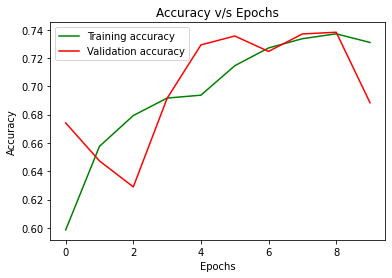

In [ ]:
accuracy_train = history.history['accuracy']
accuracy_val=  history.history['val_accuracy']
plt.plot( accuracy_train, 'g', label='Training accuracy')
plt.plot( accuracy_val, 'r', label='Validation accuracy')
plt.title('Accuracy v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

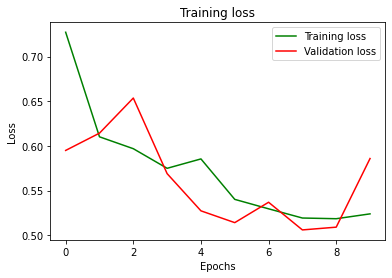

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot( loss_train, 'g', label = 'Training loss' )
plt.plot( loss_val, 'r', label = 'Validation loss' )
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/brain3.h5')

OSError: ignored

In [ ]:
model.evaluate(test_generator1, verbose=1)

124/124 [==============================] - 55s 439ms/step - loss: 0.9490 - accuracy: 0.5737


[0.9490000009536743, 0.5736815333366394]

In [ ]:
predictions = model.predict(test_generator, verbose=1)

124/124 [==============================] - 53s 428ms/step


In [ ]:
predictions

array([[0.20213014, 0.7978699 ],
       [0.2086199 , 0.7913801 ],
       [0.13065946, 0.8693406 ],
       ...,
       [0.26034418, 0.7396558 ],
       [0.20589599, 0.794104  ],
       [0.76973563, 0.23026437]], dtype=float32)

In [ ]:
final_result = []
i = 0
for patient in patients_test:
    length = len(glob('/content/drive/MyDrive/Brain/test/' + patient +'/FLAIR/*.png'))
    final_result.append(predictions[i:i+length, 1].sum()/length)
    i += length
    
final_result

[0.8238339424133301,
 0.822140393938337,
 0.5919862853156196,
 0.7365011157411517,
 0.7626882203867738,
 0.6947837457424257,
 0.7431095971001519,
 0.9090449277477985,
 0.6724272487002335,
 0.90464428887851,
 0.6369573693526419,
 0.6288375854492188,
 0.5685061500186012,
 0.6222880227225167,
 0.4505248750959124,
 0.4793547717007724,
 0.7541786585098658,
 0.6232729893104703,
 0.6529384281324304,
 0.8453624725341797,
 0.5783641815185547,
 0.6306093094196725,
 0.7566333770751953,
 0.6923973560333252,
 0.5647783482328375,
 0.8473398685455322,
 0.7244057655334473,
 0.7419150808583135,
 0.822593844666773,
 0.5708359371532093,
 0.7347591824001736,
 0.6118044172014508,
 0.4963798117130361,
 0.6834782409667969,
 0.6399052937825521,
 0.5671265072292752,
 0.516462894196206,
 0.8216834372662484,
 0.5555213689804077,
 0.7047449747721354,
 0.7035320506376379,
 0.6173401690543966,
 0.6328182220458984,
 0.632685032296688,
 0.6307424757215712,
 0.4838142395019531,
 0.6634965515136719,
 0.5829174253675673

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Brain/sample_submission.csv')
test

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
...,...,...
82,826,0.5
83,829,0.5
84,833,0.5
85,997,0.5


In [ ]:
submission = pd.DataFrame({"BraTS21ID": test['BraTS21ID'].apply(lambda x: str(x).zfill(5)), "MGMT_value": final_result})
submission

,BraTS21ID,MGMT_value
0,00001,0.823834
1,00013,0.822140
2,00015,0.591986
3,00027,0.736501
4,00037,0.762688
...,...,...
82,00826,0.554802
83,00829,0.653178
84,00833,0.594943
85,00997,0.664130


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=test_generator1.labels, y_pred=np.argmax(predictions, axis=1))

In [ ]:
    import itertools    
    def plot_confusion_matrix(cm, classes, normalize=False, title='Condusion Matrix', cmap=plt.cm.Blues):
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation=45)
      plt.yticks(tick_marks, classes)


      if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
        print("Normalized CM")
      else:
        print("CM without Normalization")  
      print(cm)   

      threshold = cm.max() / 2.

      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, cm[i, j], horizontalalignment="center", color='white' if cm[i,j] > threshold else "black")

CM without Normalization
[[ 393 2855]
 [ 524 4154]]


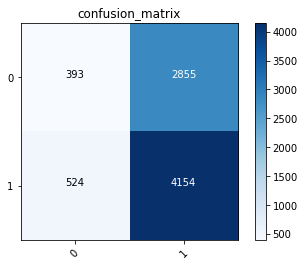

In [ ]:
cm_plot_labels = ['0','1']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='confusion_matrix')

In [ ]:
test_dataset = pd.DataFrame({'path' : glob('/content/drive/MyDrive/Brain/test/00001/FLAIR/*.png')})

for i, patient in enumerate(patients_test[1:]):
    data_slice = pd.DataFrame({'path' : glob('/content/drive/MyDrive/Brain/test/' + patient +'/FLAIR/*.png')})
    test_dataset = pd.concat([test_dataset, data_slice])
    
test_dataset = test_dataset.reset_index(drop = True)
test_dataset

In [ ]:
test_dataset1 = pd.DataFrame({'path' : glob('/content/drive/MyDrive/Brain/test/00001/FLAIR/*.png'),
                              'label' : 1})

for i, patient in enumerate(patients_test[1:]):
    data_slice = pd.DataFrame({'path' : glob('/content/drive/MyDrive/Brain/test/' + patient +'/FLAIR/*.png'),
                               'label' : df['MGMT_value'][i+1]})
    test_dataset1 = pd.concat([test_dataset1, data_slice])
    
test_dataset1 = test_dataset1.reset_index(drop = True)
test_dataset1['label'] = test_dataset1['label'].astype(str)
test_dataset1

,path,label
0,/content/drive/MyDrive/Brain/test/00001/FLAIR/...,1
1,/content/drive/MyDrive/Brain/test/00001/FLAIR/...,1
2,/content/drive/MyDrive/Brain/test/00001/FLAIR/...,1
3,/content/drive/MyDrive/Brain/test/00001/FLAIR/...,1
4,/content/drive/MyDrive/Brain/test/00001/FLAIR/...,1
...,...,...
7921,/content/drive/MyDrive/Brain/test/01006/FLAIR/...,0
7922,/content/drive/MyDrive/Brain/test/01006/FLAIR/...,0
7923,/content/drive/MyDrive/Brain/test/01006/FLAIR/...,0
7924,/content/drive/MyDrive/Brain/test/01006/FLAIR/...,0


In [ ]:
test_generator1 = idg3.flow_from_dataframe(test_dataset1, x_col = 'path', y_col = 'label', target_size = (224, 224), batch_size = 64, class_mode='categorical', shuffle = False)

Found 7926 validated image filenames belonging to 2 classes.
